### This ananlysis uses FPL dataset from FPL API. The ultimate goal is to be able to build models so that we can predict player points for the upcoming FPL game week.

Specifically, we will: 
    
    1. Load in the FPL players datasets in JSON
    2. Build pandas dataframes for 22/23 season with current price
    3. Conduct some EDA
    4. Split the data into train and test
    5. Find the optimal parameters for each model and evaluate performance
    6. Fit the models for prediction
    7. Make prediction

    
Hopefully after this analysis we will be able to answer the following questions: 
 - How to obtain FPL dataset in desired format ready for analysis?
 - What are the valuable players based on previous season performance given current price?
 - What are some good predictors of FPL player points for the upcoming game week?
 - What predictors are correlated, therefore should be dropped before modelling?
 - How to construct modelling to balance bias and variance?
 - How to finetune model parameters to avoid overfitting?
 - What is the predicted player points for upcoming FPL game week using models trained?

In [155]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
import requests
import json
from IPython.display import HTML
from numpy.random import random
%matplotlib inline

import warnings
import chardet
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

#### A detailed guide to all currently available Fantasy Premier League API endpoints: 
https://medium.com/@frenzelts/fantasy-premier-league-api-endpoints-a-detailed-guide-acbd5598eb19

In [156]:
# function to request json over url
def getJson(base_url, end_point_path, element_id=''):
    return requests.get(base_url+end_point_path+str(element_id)).json()

In [157]:
# get json data
base_url = 'https://fantasy.premierleague.com/api/'
end_point_general = 'bootstrap-static'
end_point_fixtures = 'fixtures'
end_point_player = 'element-summary/'

json = getJson(base_url, end_point_general)
# check keys
json.keys()

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])

#### Desired data
##### Dataframe #1:
- all 38 game week of season 22/23
- all 10 games of each 38 game week of season 22/23
- all players involved [i.e. ~(11 + 4) x 2] for all 10 games in each 38 game week of season 22/23

Expected number of records = 38 x 10 x (11 + 4) x 2 = ~11.4K

##### Dataframe #2:
- current player info including cost, position etc.

##### Dataframe #3:
- Join df1 and df2 to get aggregated df for info such as value = average points per minute / current cost

In [158]:
# build dataframes
df_elements = pd.DataFrame(json['elements'])
df_elements_types = pd.DataFrame(json['element_types'])
df_teams = pd.DataFrame(json['teams'])
total_players = json['total_players']
percentile = 0.8

df_elements_short = df_elements[['id', 'first_name', 'second_name','team','element_type','selected_by_percent','now_cost','minutes','transfers_in','value_season','event_points', 'total_points']]

# restructure player dataframe
df_elements_short['position'] = df_elements_short.element_type.map(df_elements_types.set_index('id').singular_name)
df_elements_short['team'] = df_elements_short.team.map(df_teams.set_index('id').name)
df_elements_short['name'] = df_elements_short['first_name'] + ' ' + df_elements_short['second_name']
df_elements_short['points_per_minute'] = df_elements_short['total_points'] / df_elements_short['minutes']
df_elements_short['points_per_minute'] = df_elements_short['points_per_minute'].fillna(0)
df_elements_short['now_cost'] = df_elements_short['now_cost'] / 10
df_elements_short['ppm_over_cost'] = df_elements_short['points_per_minute'] / df_elements_short['now_cost']
df_elements_short = df_elements_short[df_elements_short['minutes'] >= df_elements_short['minutes'].quantile(percentile)]
df_elements_short = df_elements_short[['id', 'name', 'team', 'position', 'selected_by_percent', 'minutes', 'now_cost', 'points_per_minute', 'ppm_over_cost']]

In [159]:
# show value players
df_elements_short = df_elements_short.sort_values(by=['ppm_over_cost'], ascending=False)
df_elements_short.groupby(['position']).head(5)

,id,name,team,position,selected_by_percent,minutes,now_cost,points_per_minute,ppm_over_cost
25,26,Leandro Trossard,Arsenal,Midfielder,2.7,2237,7.0,0.068842,0.009835
416,402,Miguel Almirón Rejala,Newcastle,Midfielder,6.2,2487,6.5,0.063530,0.009774
282,275,Bernd Leno,Fulham,Goalkeeper,9.2,3240,4.5,0.043827,0.009739
116,113,David Raya Martin,Brentford,Goalkeeper,9.9,3420,5.0,0.048538,0.009708
19,20,William Saliba,Arsenal,Defender,14.8,2415,5.0,0.048447,0.009689
154,151,Joël Veltman,Brighton,Defender,1.3,2183,4.5,0.043518,0.009671
515,495,Ben Davies,Spurs,Defender,0.7,2284,4.5,0.043345,0.009632
134,131,Pervis Estupiñán,Brighton,Defender,51.2,2674,5.0,0.047868,0.009574
390,377,Diogo Dalot Teixeira,Man Utd,Defender,2.0,2152,5.0,0.047398,0.009480
231,226,Eberechi Eze,Crystal Palace,Midfielder,12.2,2631,6.5,0.060433,0.009297


In [160]:
df_mo = df_elements_short[(df_elements_short['name']=='Mohamed Salah')]
df_mo

,id,name,team,position,selected_by_percent,minutes,now_cost,points_per_minute,ppm_over_cost
316,308,Mohamed Salah,Liverpool,Midfielder,24.6,3290,12.5,0.072644,0.005812


In [161]:
element_id = 308
json = getJson(base_url, end_point_player, element_id)
# check keys
json.keys()

dict_keys(['fixtures', 'history', 'history_past'])

In [162]:
df_player_mo = pd.DataFrame(json['history_past'])
df_player_mo.tail()

,season_name,element_code,start_cost,end_cost,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded
3,2018/19,118748,130,132,259,3254,22,12,21,20,0,0,0,1,0,0,18,687,1186.8,973.9,2168.0,432.7,0,0.00,0.00,0.00,0.00
4,2019/20,118748,125,125,233,2879,19,10,16,26,0,0,0,1,0,0,26,661,1061.2,834.8,2156.0,405.1,0,0.00,0.00,0.00,0.00
5,2020/21,118748,120,129,231,3077,22,6,11,41,0,0,0,0,0,0,21,657,1056.0,825.7,1980.0,385.8,0,0.00,0.00,0.00,0.00
6,2021/22,118748,125,131,265,2758,23,14,17,22,0,0,1,1,0,0,29,756,1241.0,875.9,2230.0,434.8,0,0.00,0.00,0.00,0.00
7,2022/23,118748,130,131,239,3290,19,13,13,45,0,0,2,2,0,0,23,651,1067.4,899.2,1688.0,365.6,37,21.01,7.03,28.04,47.47


##### Data limiation
From observation above, FPL API doesn't have player level game week data for past seasons

##### Solution
Use github repo https://github.com/vaastav/Fantasy-Premier-League/tree/master loaded to local repo

In [163]:
# helper functions to retrieve players master dataframe based on seasons interested
def getEncoding(file):
    with open(file, 'rb') as rawdata:
        result = chardet.detect(rawdata.read(100000))
    return result['encoding']

def getMasterDataFrame(seasons):
    for i, season in enumerate(seasons):

        file = 'Fantasy-Premier-League/data/'+ season +'/gws/merged_gw.csv'
        encoding = getEncoding(file)

        if i == 0:
            df_master = pd.read_csv(file, encoding=encoding)
            df_master['season'] = season
        else:
            df_temp = pd.read_csv(file, encoding=encoding)
            df_temp['season'] = season
            df_master = pd.concat([df_master, df_temp], ignore_index=True)
    return df_master

In [164]:
# retrieve player master dataframe by specifying seasons intended to pull
# i.e. to pull player data for season 22/23, assign seasons = ['2022-23']
seasons = ['2022-23', '2021-22', '2020-21']

df_master = getMasterDataFrame(seasons)

df_master = df_master.merge(df_elements_short[['name','selected_by_percent', 'now_cost']], on='name', how='right')

In [165]:
# validation with seasonally aggregated data for Salah above
df_mo = df_master[df_master['name'].str.contains('Salah')]
df_mo.groupby(['season'])['total_points'].sum()

season
2020-21    231.0
2021-22    265.0
2022-23    239.0
Name: total_points, dtype: float64

Validation complete, numbers match for seasons 22/23, 21/22 and 20/21

In [166]:
# calculate efficient frontier
df_efficient_frontier = df_master[['name', 'team', 'element', 'total_points', 'season', 'now_cost']]
df_efficient_frontier['points_return'] = df_efficient_frontier['total_points'] / df_efficient_frontier['now_cost']
df_std = df_efficient_frontier.groupby(['name', 'team'])['points_return'].std().reset_index()
df_std = df_std.rename(columns={df_std.columns[0]: 'name', df_std.columns[1]: 'team', df_std.columns[2]: 'pts_rt_std'})
df_rt = df_efficient_frontier.groupby(['name', 'team'])['points_return'].mean().reset_index()
df_rt = df_rt.rename(columns={df_rt.columns[0]: 'name', df_rt.columns[1]: 'team', df_rt.columns[2]: 'ave_pts_rt'})
df_eft = df_rt.merge(df_std, on=['name', 'team'], how='left')
df_eft['adj_pts_rt'] = df_eft['ave_pts_rt'] / df_eft['pts_rt_std']
df_eft = df_eft.merge(df_elements_short[['name', 'team', 'position', 'selected_by_percent', 'now_cost']], on=['name', 'team'], how='right')
df_eft = df_eft.sort_values(by=['adj_pts_rt'], ascending=False)
df_eft.head(20)

,name,team,ave_pts_rt,pts_rt_std,adj_pts_rt,position,selected_by_percent,now_cost
116,Idrissa Gueye,Everton,0.400000,0.193649,2.065591,Midfielder,0.0,5.0
117,Moisés Caicedo Corozo,Brighton,0.415789,0.252047,1.649650,Midfielder,2.6,5.0
118,Remo Freuler,Nott'm Forest,0.300000,0.188225,1.593839,Midfielder,0.0,5.0
10,Benjamin White,Arsenal,0.746411,0.499791,1.493446,Defender,9.7,5.5
76,Ederson Santana de Moraes,Man City,0.695375,0.492314,1.412462,Goalkeeper,13.9,5.5
100,Bruno Borges Fernandes,Man Utd,0.544892,0.402388,1.354145,Midfielder,24.5,8.5
17,Sven Botman,Newcastle,0.754386,0.560136,1.346791,Defender,26.8,4.5
104,Harry Kane,Spurs,0.489123,0.367726,1.330129,Forward,14.6,12.5
22,Gabriel Martinelli Silva,Arsenal,0.651316,0.492475,1.322535,Midfielder,14.2,8.0
26,Nick Pope,Newcastle,0.751196,0.575225,1.305916,Goalkeeper,13.0,5.5


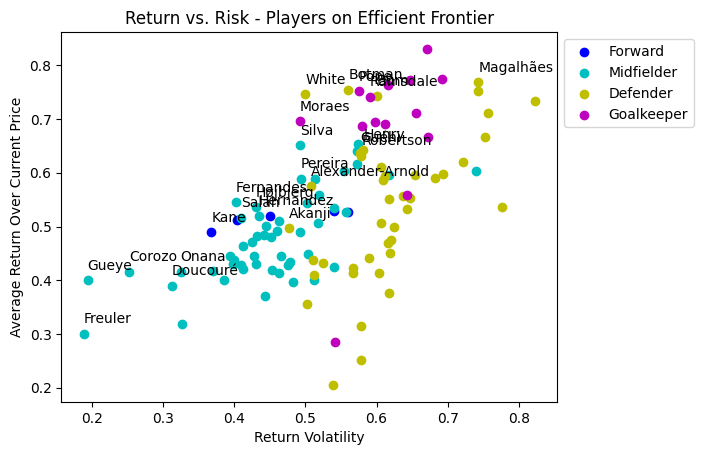

In [167]:
colors = {'Forward': 'b', 'Midfielder': 'c', 'Defender': 'y', 'Goalkeeper': 'm'}

for i, position in enumerate(colors.keys()):

    df = df_eft[df_eft['position'] == position]
    x = list(df['pts_rt_std'])
    y = list(df['ave_pts_rt'])
    plt.scatter(x, y, color=colors[position])
    for j, player in enumerate(df['name']):
        if float(list(df['adj_pts_rt'])[j]) >= df['adj_pts_rt'].quantile(0.8):
            plt.annotate(player.split(' ')[-1], (x[j], y[j] + 0.02))

plt.legend(colors.keys(),
           bbox_to_anchor=(1 , 1),
           ncol=1)
plt.title('Return vs. Risk - Players on Efficient Frontier')
plt.xlabel('Return Volatility')
plt.ylabel('Average Return Over Current Price')
plt.show()

##### Data limiation
Predictors from FPL (i.e. threat, ICT index, influence) are most lagging indicators, lack of player attributes predictors

##### Solution
Feature engineer player attribute predictors from FIFA and Football Manager